In [1]:
import sys
import pandas as pd
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None

# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from isolation_forest import *
from reittien_erottelu import *
from sisään_uloskäynnit import *
# tai from ... import *

# Database query

In [2]:
df = database_query("SELECT * FROM SensorData")
df.head(5)

node_id                            timestamp     x    y  \
0  b'-2393099149039893833'  b'2020-06-24 12:20:08.533016+00:00'  2762 -257   
1  b'-2393099149039893833'  b'2020-06-24 12:20:08.620015+00:00'  2870 -344   
2  b'-2393099149039893833'  b'2020-06-24 12:20:09.622827+00:00'  2916 -344   
3  b'-2393099149039893833'  b'2020-06-24 12:20:09.622846+00:00'  2894 -254   
4  b'-2393099149039893833'  b'2020-06-24 12:20:10.116102+00:00'  2888 -188   

     z  q  
0  100  0  
1  100  0  
2  100  0  
3  100  0  
4  100  0

# Histogram of x and y coordinates

x mean:  1721.8087923854644
y mean:  680.035106133466
x std:  1031.8899924277641
y std:  1088.7371382819924


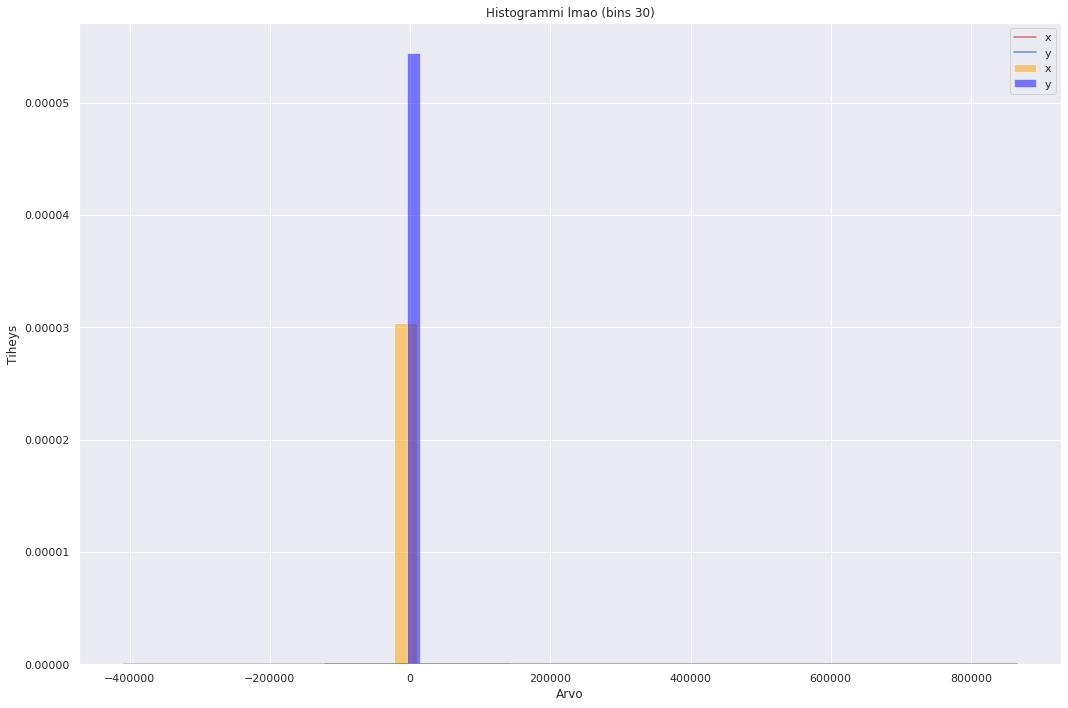

In [7]:
draw_histogram(df['x'], df['y'], 30)

# Find outliers using z_score

Number of missing variables in table
 node_id      0
timestamp    0
x            0
y            0
z            0
q            0
dtype: int64
------------------------------
Unique values in columns

uniques in x 10532
uniques in y 7899
uniques in z 3
uniques in q 1
------------------------------
Checking z and q columns

uniques in z [100 400   0]
uniques in q [0]
------------------------------
Number of nodes: 32
------------------------------
Outliers

Data with outliers:  13890906
Ouliers removed:     376791
Data after:  13514115


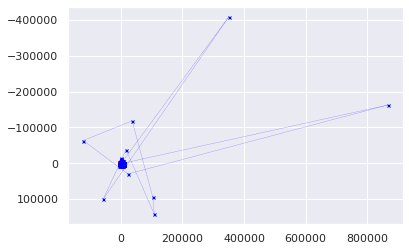

In [3]:
df1 = find_outliers(df)

# Cleaning Node_id, timestamp, q, z columns

In [4]:
df1 = clean_dataframe(df1)
df1.head(5)

index  node_id               timestamp     x    y
0      0        1 2020-06-24 15:20:08.533  2762 -257
1      1        1 2020-06-24 15:20:08.620  2870 -344
2      2        1 2020-06-24 15:20:09.623  2916 -344
3      3        1 2020-06-24 15:20:09.623  2894 -254
4      4        1 2020-06-24 15:20:10.116  2888 -188

# Tehdään uuten tiedostoon Isolation Forestilla putsatut nodet

In [8]:
for i in range(32):
    df1_node = isolation_forest(df1, 0, .003, i+1)
    print('node numero', i+1, 'valmis')
    df1_node = df1_node.drop(columns='index')
    if i == 0:
        df1_node.to_csv('./data/temp_data.csv', index=False)
    else:
        df1_node.to_csv('./data/temp_data.csv',mode='a', header=False, index=False)

Dataframe lenght before: 545350
Dataframe lenght after: 543713
Total outliers detected: 1637
node numero 1 valmis
Dataframe lenght before: 242868
Dataframe lenght after: 242139
Total outliers detected: 729
node numero 2 valmis
Dataframe lenght before: 329461
Dataframe lenght after: 328472
Total outliers detected: 989
node numero 3 valmis
Dataframe lenght before: 678810
Dataframe lenght after: 676773
Total outliers detected: 2037
node numero 4 valmis
Dataframe lenght before: 238262
Dataframe lenght after: 237547
Total outliers detected: 715
node numero 5 valmis
Dataframe lenght before: 246270
Dataframe lenght after: 245531
Total outliers detected: 739
node numero 6 valmis
Dataframe lenght before: 454213
Dataframe lenght after: 452850
Total outliers detected: 1363
node numero 7 valmis
Dataframe lenght before: 239272
Dataframe lenght after: 238554
Total outliers detected: 718
node numero 8 valmis
Dataframe lenght before: 405176
Dataframe lenght after: 403960
Total outliers detected: 1216


In [9]:
df1 = pd.read_csv('./data/temp_data.csv')
df1.shape

(11576225, 4)

# Poistetaan vialliset / puutteelliset nodet

In [10]:
df1 = df1[df1.node_id != 13]
df1 = df1[df1.node_id != 14]
df1 = df1[df1.node_id != 18]
df1 = df1[df1.node_id != 32]

# Adding xy_grid values to dataframe (50x50)

In [11]:
grid_size = 50
df1 = xy_to_grid(df1, df1.x, df1.y, grid_size)
df1.head()

node_id                timestamp     x    y  x_grid  y_grid  grid_id
0        1  2020-06-24 15:20:08.533  2762 -257      37      15      787
1        1  2020-06-24 15:20:08.620  2870 -344      38      14      738
2        1  2020-06-24 15:20:09.623  2916 -344      38      14      738
3        1  2020-06-24 15:20:09.623  2894 -254      38      15      788
4        1  2020-06-24 15:20:10.116  2888 -188      38      16      838

# Write cleaned and diskretized dataframe to mariadb database

In [12]:
#SUPER DANGEROUS
#write_df_to_mariadb(df1)

# Find and draw exits

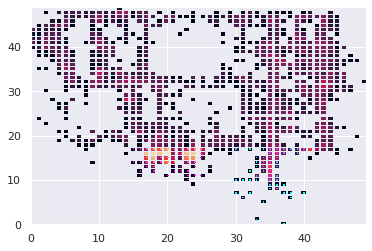

In [19]:
in_x, in_y = sisään(df1)
out_x, out_y = ulos(df1)

draw_exits(df1, in_x, in_y, out_x, out_y)

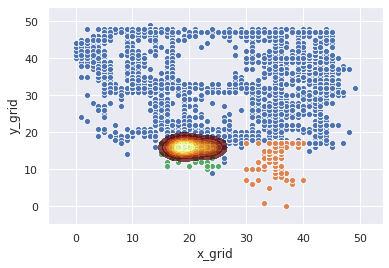

In [27]:
# Muokataan sisäänkäynnin ja kassojen sijainnit ID-muotoon.
in_ID = xy_to_ID(in_x,in_y, grid_size)
out_ID = xy_to_ID(out_x,out_y, grid_size)

# # Voidaan tarkistaa sijaintien oikeellisuus
sns.scatterplot(x="x_grid", y="y_grid", data = df1)
sns.scatterplot(x=in_x, y=in_y)
sns.scatterplot(x=out_x, y=out_y)
hmax= sns.kdeplot(df1.x_grid, df1.y_grid, cmap="afmhot", shade=True, alpha = 0.7)
hmax.collections[3].set_alpha(0)
plt.show()


### Erotetaan kauppareissut toisistaan

In [28]:
# Haetaan uniikit id:t
u_in_ID = in_ID.unique()
u_out_ID = out_ID.unique()

reitit = erottele_reitit(df1, u_in_ID, u_out_ID)

reitit = poista_lyhyet_reitit(reitit, 50)
df_reitit = reitit_dataframeksi(reitit)


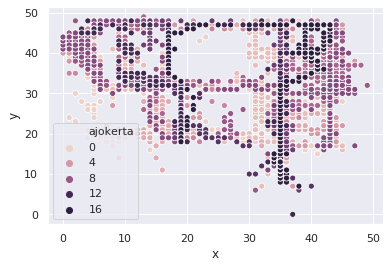

In [30]:
# Plotataan kaikki erotellut kauppareissut yhdessä
plot_all_routes(df_reitit, grid_size)

445


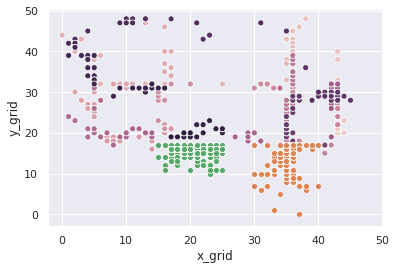

574


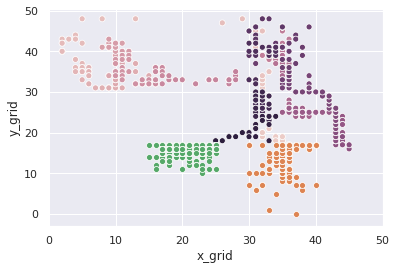

403


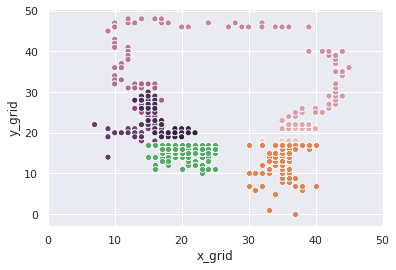

348


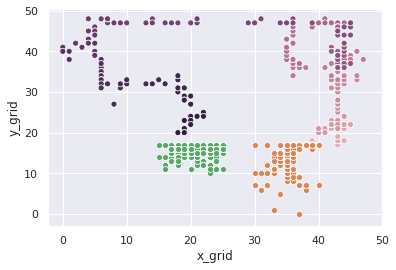

201


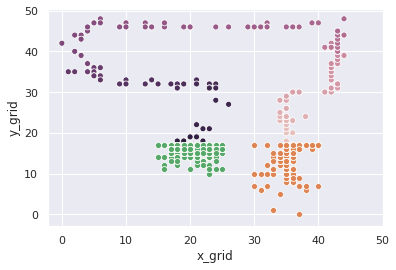

432


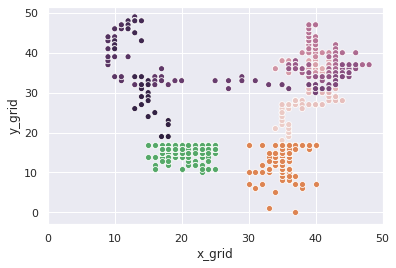

270


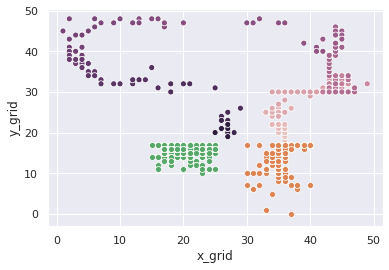

392


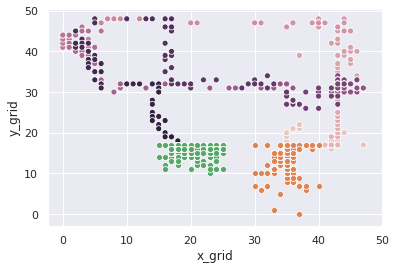

150


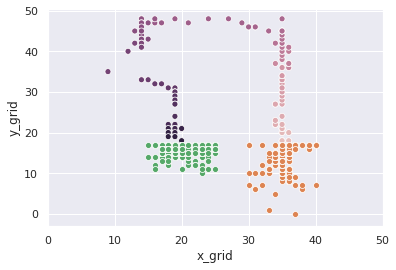

79


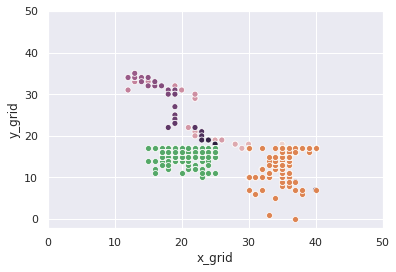

201


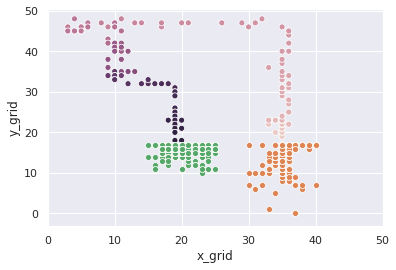

436


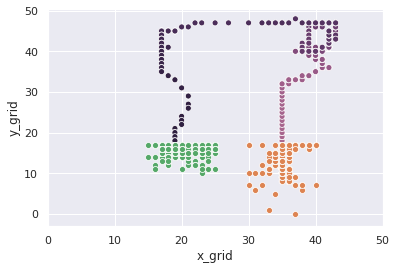

In [31]:
# Plottaa jokaisen kauppareissut erikseen.

plot_unique_routes(df_reitit, grid_size, in_x, in_y, out_x, out_y)   
# Ensimmäisissä on aika paljon häiriötä